In [1]:
## PARTIE 1: IMPLEMENTATION DE L'ESTIMATION CONTINUE DE LA VRAISEMBLANCE A L'AIDE D'UN FILTRE PARTICULAIRE

import numpy as np
import scipy.stats
from scipy.stats import uniform
import scipy.optimize
from scipy.optimize import minimize
import math
import sympy
from sympy import DiracDelta
import matplotlib.pyplot as plt

## Implementation du filtre a particule pour les SV-GARCH

def initial_values(y, v, M, L, gamma, alpha, beta, phi): ## l est le lag choisit tel qu'indique dans l'article
    v_L = [v[L] for k in range(M)]
    for lag in range(L):
        for i in range(M):
            v_L[i] = (v_L[i]-gamma)/(alpha + beta*(phi*np.random.normal(0, 1, size = 1) + np.sqrt(1-phi**2)*np.random.normal(0, 1, size = 1))**2)
    v_0 = v_L
    return v_0
    
    
def particle_filtering(y, v, M, L, gamma, alpha, beta, phi): #y is an array of observed data, v is an array of simulated particles, M is the FP sample size
    v_sim = [[0 for k in range(M)] for m in range(len(y))]
    v_f = v_sim
    w = [[0 for k in range(M)] for m in range(len(y))] 
    l = [[0 for k in range(M)] for m in range(len(y))] # stocke les poids lambda de chaque simulation
    ## on chope d'abord M valeurs v_0
    v_0 = initial_values(y, v, M, L, gamma, alpha, beta, phi)
    v_sim[0] = v_0
    ## on execute la partie iterative de l'algorithme
    for t in range(1,len(y)):
        
        for i in range(M):
            v_sim[t][i] = gamma + alpha*v_sim[t-1][i] + beta*v_sim[t-1][i]*(phi*np.random.normal(0, 1, size = 1) + np.sqrt(1-phi**2)*np.random.normal(0, 1, size = 1))**2 #transitive kernel h_t+1|h_t,y_t
            w[t][i] = (2*np.pi*v_sim[t][i])**(-0.5)*math.exp(-0.5*y[t]/v_sim[t][i]**(0.5))
        for i in range(M):
            l[t][i] = w[t][i]/(sum(w[t]))
        
        #v_sorted = [[0 for k in range(M)] for l in range(len(y))]
        #v_sorted[i] = np.sort([v_sim[k][i] for k in range(len(y))])

        def G(x, k, i):
            #return uniform.cdf((x - v_sorted[i][k-1])/(v_sorted[i][k] - v_sorted[i][k-1]))
            return uniform.cdf((x - v_sim[k-1][i])/(v_sim[k][i] - v_sim[k-1][i]))
        def F(x, k):
            return sum([l[k][i]*G(x, k, i) for i in range(M-1)])
        
        for j in range(M-1):
            v_f[t][j] = F(v_sim[t][j], t)
    return v_f

In [2]:
def simulate_svgarch(gamma, alpha, beta, T): #alpha + beta < 1
    y = [0 for t in range(T)]
    v = [0 for t in range(T)]
    v[0] = gamma/(1 - alpha - beta)
    for t in range(T-1):
        eps = np.random.normal(0 , 1, size = 1)
        y[t] = np.sqrt(v[t])*eps
        v[t+1] = gamma + alpha*v[t] + beta*y[t]**2
    return y, v

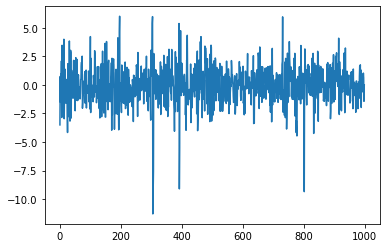

In [3]:
y, v = simulate_svgarch(1,0.3,0.4, 1000)
plt.plot(y)

In [4]:
# definition de la log-vraisemblance
M = 100
l = 10

def neg_log_likelihood(theta): # theta = [gamma, alpha, beta, phi]
    filter_data = particle_filtering(y, v, M, l, theta[0], theta[1], theta[2], theta[3])
    return -sum(np.log(sum([filter_data[t][i] for i in range(M)])))

In [5]:
#calcul du maximum de vraisemblance

x0 = np.array([0.1, 0.1, 0.1, 0.1])
max_vrais = -minimize(neg_log_likelihood, x0, method='Nelder-Mead', tol=1e-6).x

NameError: name 't' is not defined

In [ ]:
## PARTIE 3: TEST SUR DES DONNEES REELLES